# Memory Bandwidth with STREAM, on Conway, Intel Compiler, I/O-die @ P3, DRAM @ 1600MHz

## Load necessary depencencies

In [1]:
import numpy
import csv
import re
import os
import matplotlib.pyplot as plt
import matplotlib

## Define functions

In [2]:
# taken from https://github.com/kuk/log-progress

# MIT License
#
# Copyright (c) 2016 bureaucratic-labs
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, cores, stride, retlist):
    
    for file in filelist:
        if stride == 1:
            string = "all-cores-per-CCX_" + str(cores) + "c"
        elif stride == 2:
            string = "two-cores-per-CCX_" + str(cores) + "c"
      
        if string in file:
            retlist.append(file) 
            break

In [4]:
# calculate averages and standard deviations from values in file list for all instructions in list
# size = data size which will be used as reference for evaluation
def evaluation(filelist, function):
    values = numpy.array([])
    averages = numpy.array([])
    stdevs = numpy.array([])

    core_found = False
    data_found = False


    # iterate over lines in file
    for file in filelist:

        for line in open(file):
            # check if file has data for function
            if line.startswith(function):
                core_found = True

                values = numpy.append(values, float(line.split()[1]))


    # calculate median
    # save min and max value as error
    averages = numpy.average(values)
    stdevs = numpy.std(values)

    return averages, stdevs

In [13]:
# plotter function
# frequency in GHZ, float
def plotter(averages, stdevs, function, function_index, cores, stride, arch, compiler):
    fig, ax = plt.subplots()
    
    xlabels = cores
    
    # as many x-ticks as memory locations
    x = numpy.arange(len(xlabels))

    # use cores as xticks
    ax.set_xticks(x)
    
    if stride == 1:
        xlabels = cores
        ax.set_xlabel('Number of Cores used')
        string = "\nConsecutive Cores used"
    elif stride == 2:
        xlabels = ['4\n2 CCX', '16\n1 Socket', '32\n2 Sockets']
        ax.set_xlabel('Number of Cores used\nCores spread across ...')   
        string = "\nEvery other core used"
        
    # set title according to memory level, CPU architecture, machine designation
    ax.set_title('STREAM ' + function + ' on ' + arch + ', compiled with ' + compiler + string + ', DRAM @ 1600MHz, I/P-die @ P3')
        
    ax.set_xticklabels(xlabels) 

    ax.set_ylabel('Bandwidth in [GB/s]')

    # enable y-axis grid
    ax.grid(b=True, which='major', axis='y', linestyle='--', linewidth='0.4')

    # width of bars
    width = 0.5
    
    if stride == 1:
        ax.axvline(x=3.5, color='grey', linestyle="--")
        ax.axvline(x=4.5, color='grey', linestyle="--")
        ax.axvline(x=5.5, color='grey', linestyle="--")
        ax.axvline(x=6.5, color='grey', linestyle="--")
    elif stride == 2:
        ax.axvline(x=0.5, color='grey', linestyle="--")
        ax.axvline(x=1.5, color='grey', linestyle="--")
        ax.axvline(x=2.5, color='grey', linestyle="--")
        
    rect1 = ax.bar(x, averages[function_index]/1024, width, yerr=stdevs[function_index]/1024, xerr=0)

    
    # print values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 5+height,
                    '%d' % round(height, 2),
                rotation=90, ha='center', va='bottom', size='xx-small')
            
    autolabel(rect1)

    # set y axis limit identical for all plots for consistent looks & fitting bar labels
    ax.set_ylim(top=round(numpy.max(averages[function_index])/1024)+25)
    
    # plot legend
    # ax.legend(fontsize='x-small')

    # ensure that xticks-labels are being shown on saved plot
    fig.tight_layout()
        
    # save plot to file
    filename = arch + '-' + compiler + '-STREAM-'+ function + '-stride_' + str(stride) + '-DRAM_1600MHz-P3.png'
    
    matplotlib.pyplot.savefig(filename, dpi=300, format='png') 
    print(filename + ' has been saved to disk.')

## Create file lists

In [6]:
# get list of all files in directory
path = 'intel-AMD'

filelist = []

for entry in log_progress(os.scandir(path), True): 
    filelist.append(entry.path)

In [7]:
files_stride1 = [],[],[],[],[],[],[] # array index equals index of cores
files_stride2 = [],[],[],[] # array index equals index of cores

cores_stride1 = ['1', '2', '3', '4', '8', '32', '64'] 
cores_stride2 = ['4', '16', '32']

for cores in log_progress(cores_stride1):
    index = cores_stride1.index(cores)
    
    listgenerator(filelist, cores, 1, files_stride1[index])
    
    print("Files in list for cores: " + str(cores) + ': ' + str(len(files_stride1[index])))
    
for cores in log_progress(cores_stride2):
    index = cores_stride2.index(cores)
    
    listgenerator(filelist, cores, 2, files_stride2[index])
    
    print("Files in list for cores: " + str(cores) + ': ' + str(len(files_stride2[index])))

Files in list for cores: 1: 1
Files in list for cores: 2: 1
Files in list for cores: 3: 1
Files in list for cores: 4: 1
Files in list for cores: 8: 1
Files in list for cores: 32: 1
Files in list for cores: 64: 1


Files in list for cores: 4: 1
Files in list for cores: 16: 1
Files in list for cores: 32: 1


In [8]:
print(files_stride2)

(['intel-AMD/intel_1S_two-cores-per-CCX_4c.txt'], ['intel-AMD/intel_1S_two-cores-per-CCX_16c.txt'], ['intel-AMD/intel_2S_two-cores-per-CCX_32c.txt'], [])


## Process data

In [9]:
functions = ['Copy', 'Scale', 'Add', 'Triad']

averages_stride1 = numpy.zeros([len(functions), len(cores_stride1)])
stdevs_stride1 = numpy.zeros([len(functions), len(cores_stride1)])

averages_stride2 = numpy.zeros([len(functions), len(cores_stride2)])
stdevs_stride2 = numpy.zeros([len(functions), len(cores_stride2)])

for function in log_progress(functions):
    function_index = functions.index(function)
    
    for core in cores_stride1:
        core_index = cores_stride1.index(core)
        
        averages_stride1[function_index][core_index], \
        stdevs_stride1[function_index][core_index] = \
        evaluation(files_stride1[core_index], function)
        
    for core in cores_stride2:
        core_index = cores_stride2.index(core)
        
        averages_stride2[function_index][core_index], \
        stdevs_stride2[function_index][core_index] = \
        evaluation(files_stride2[core_index], function)

## Plot data

AMD 7502-Intel-STREAM-Copy-stride_1-DRAM_1600MHz-P3.png has been saved to disk.
AMD 7502-Intel-STREAM-Copy-stride_2-DRAM_1600MHz-P3.png has been saved to disk.
AMD 7502-Intel-STREAM-Scale-stride_1-DRAM_1600MHz-P3.png has been saved to disk.
AMD 7502-Intel-STREAM-Scale-stride_2-DRAM_1600MHz-P3.png has been saved to disk.
AMD 7502-Intel-STREAM-Add-stride_1-DRAM_1600MHz-P3.png has been saved to disk.
AMD 7502-Intel-STREAM-Add-stride_2-DRAM_1600MHz-P3.png has been saved to disk.
AMD 7502-Intel-STREAM-Triad-stride_1-DRAM_1600MHz-P3.png has been saved to disk.
AMD 7502-Intel-STREAM-Triad-stride_2-DRAM_1600MHz-P3.png has been saved to disk.


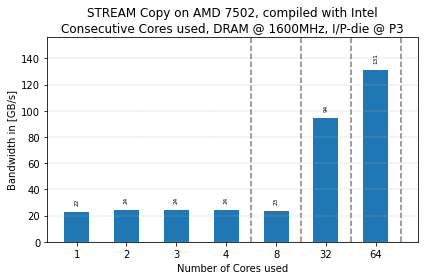

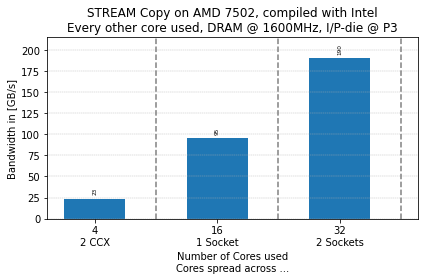

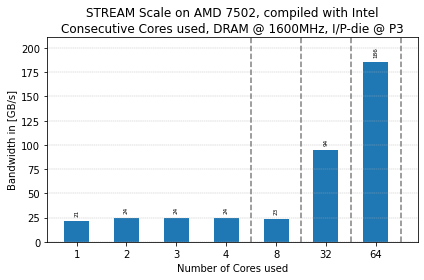

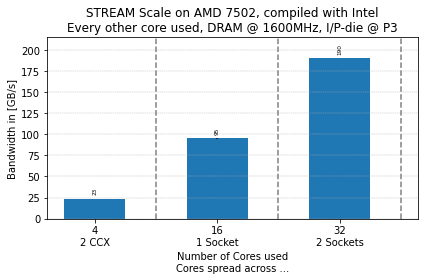

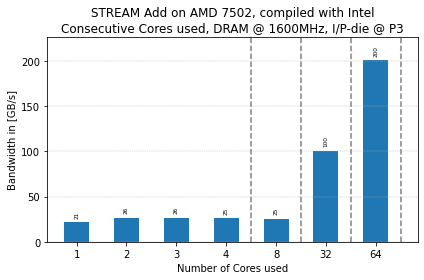

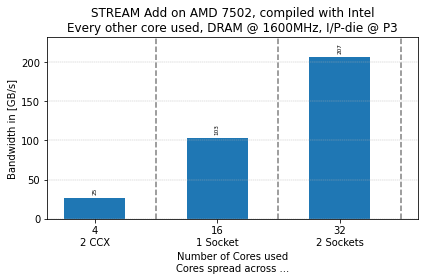

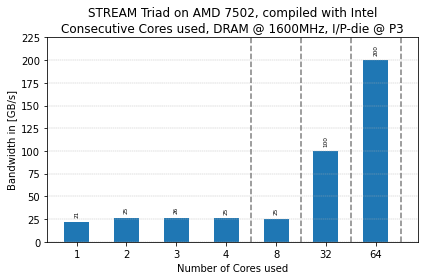

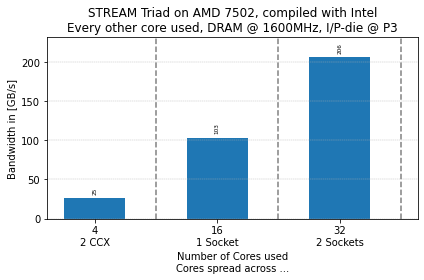

In [14]:
# plotter(averages, stdevs, function, function_index, cores, machine, arch, compiler):
for function in log_progress(functions):
    function_index = functions.index(function)
    
    plotter(averages_stride1, stdevs_stride1, function, function_index, cores_stride1, 1, 'AMD 7502', 'Intel')
    plotter(averages_stride2, stdevs_stride2, function, function_index, cores_stride2, 2, 'AMD 7502', 'Intel')